ref: https://www.tensorflow.org/tutorials/generative/cyclegan

In [ ]:
#To import pix2pix
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-qvvvqf3o
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-qvvvqf3o
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=df48e5d17e5dae6e14189c8ae0ae654def4501c21277cb29e26f7e896acc5f94
  Stored in directory: /tmp/pip-ephem-wheel-cache-ae150t0h/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


## Importing Dependencies

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import pandas as pd
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading Data

In [ ]:
# folder path for dataset
folder_path = "/content/drive/MyDrive/small_project"
rembrandt_path = "/content/drive/MyDrive/small_project/Rembrandt"
photos_path = "/content/drive/MyDrive/small_project/klagenfurt_data"


In [ ]:
from PIL import Image
import os

def resize_image_with_high_quality(input_path, output_path, target_size=(512, 512)):
    with Image.open(input_path) as img:
        # Resizing the image using Lanczos resampling
        img = img.resize(target_size, Image.LANCZOS)

        # Save the resized image
        img.save(output_path, format=img.format, quality=95) # Adjust quality for formats that support it

def resize_images_in_directory(input_directory, output_directory, target_size=(512, 512)):
    # Create the output directory if it doesn't exist
    if not os.path.isdir(output_directory):
        os.makedirs(output_directory)

    # Iterate through each file in the input directory
    for filename in os.listdir(input_directory):
        file_path = os.path.join(input_directory, filename)
        if os.path.isfile(file_path) and file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            # Construct the full paths for input and output
            output_file_path = os.path.join(output_directory, filename)

            # Resize with high quality
            resize_image_with_high_quality(file_path, output_file_path, target_size)

            print(f'Resized and saved: {output_file_path}')

# Usage example
resize_images_in_directory(photos_path, photos_path)

In [ ]:
resize_images_in_directory(rembrandt_path , rembrandt_path )

Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_133.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_74.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_250.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_65.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_64.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_70.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_253.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_59.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_130.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_132.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_71.jpg
Resized and saved: /content/drive/MyDrive/small_project/Rembrandt/Rembrandt_118.jp

In [ ]:
#Model Parameters
BUFFER_SIZE = 1000
BATCH_SIZE = 1


In [ ]:
l = ['Rembrandt', 'klagenfurt_data'] # there are two types od image in dataset

# reading train  data from directory and leabeling them
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=BATCH_SIZE)

Found 369 files belonging to 2 classes.
Using 296 files for training.


In [ ]:
# Reading test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=BATCH_SIZE)

Found 369 files belonging to 2 classes.
Using 73 files for validation.


In [ ]:
#class names
class_names = train_ds.class_names
class_names

['Rembrandt', 'klagenfurt_data']

In [ ]:
for img,label in train_ds:
  print(label)
  display(img)
  break

tf.Tensor([1], shape=(1,), dtype=int32)


<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 42.25,  60.5 ,  95.75],
         [ 41.75,  60.75,  93.75],
         [ 40.  ,  59.  ,  92.  ],
         ...,
         [ 62.5 ,  25.5 ,  17.25],
         [ 64.75,  23.75,  20.75],
         [ 60.5 ,  25.  ,  23.5 ]],

        [[ 45.  ,  61.  ,  95.  ],
         [ 44.25,  60.25,  93.5 ],
         [ 39.75,  55.75,  88.75],
         ...,
         [ 63.25,  24.  ,  20.25],
         [ 63.75,  24.25,  22.5 ],
         [ 62.75,  24.25,  22.5 ]],

        [[ 42.  ,  57.5 ,  90.75],
         [ 42.5 ,  58.  ,  91.  ],
         [ 43.75,  60.5 ,  93.25],
         ...,
         [ 68.75,  24.25,  21.75],
         [ 59.75,  23.25,  22.5 ],
         [ 57.75,  23.75,  26.75]],

        ...,

        [[207.75, 208.5 , 185.25],
         [198.  , 192.5 , 179.75],
         [131.5 , 113.25,  96.75],
         ...,
         [230.5 , 227.5 , 220.5 ],
         [233.75, 228.75, 223.25],
         [229.75, 228.5 , 224.5 ]],

        [[211.25, 213.25

## Data Preprocessing

In [ ]:
def parse(image, label):
    return image, label

def filter_rembrandt(image, label):

    return tf.equal(label[0], 0)


#get photo image
def filter_photo(image, label):
    return tf.equal(label[0], 1)


In [ ]:
rembrandt_train= train_ds.map(parse).filter(filter_rembrandt)
rembrandt_test = test_ds.map(parse).filter(filter_rembrandt)

In [ ]:
#photo
photo_train= train_ds.map(parse).filter(filter_photo)
photo_test = test_ds.map(parse).filter(filter_photo)


In [ ]:
for i,l in rembrandt_train:
  print(i)
  break

tf.Tensor(
[[[[52.   45.   35.  ]
   [59.25 52.5  42.  ]
   [55.5  49.5  37.5 ]
   ...
   [49.   42.   36.  ]
   [52.   45.   39.  ]
   [46.75 39.75 31.75]]

  [[57.   49.   38.  ]
   [58.   50.   38.5 ]
   [50.5  42.5  30.  ]
   ...
   [46.   39.   33.  ]
   [48.   41.   35.  ]
   [49.   42.   34.  ]]

  [[55.5  45.5  33.5 ]
   [63.75 53.75 41.75]
   [63.25 54.   39.75]
   ...
   [43.   38.   32.  ]
   [47.   43.   34.  ]
   [43.75 39.75 30.75]]

  ...

  [[78.   67.   62.  ]
   [58.75 48.5  39.75]
   [53.5  42.   28.5 ]
   ...
   [58.25 51.25 42.75]
   [51.5  44.   34.75]
   [56.5  48.5  39.5 ]]

  [[64.5  55.5  50.  ]
   [53.   44.   36.  ]
   [53.75 45.   34.25]
   ...
   [60.75 52.5  42.  ]
   [60.   50.5  40.25]
   [71.75 60.25 50.75]]

  [[57.   50.   44.  ]
   [61.   54.   45.5 ]
   [64.25 55.25 46.25]
   ...
   [75.5  65.5  53.5 ]
   [91.   79.   67.  ]
   [86.5  72.5  61.5 ]]]], shape=(1, 256, 256, 3), dtype=float32)


# Data Preprocessing

### Train Data - Normalize, Adding Noise , random mirroring
### Test Data - Normalize


In [ ]:
#Preprocessing funcitons

#1 crop
def random_crop(image):

  cropped_image = tf.image.random_crop(
      image, size=[512, 512, 3], seed = None, name = None)

  return cropped_image


#2 normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


#3 random jitters
def random_jitter(image):
  # resizing to 360 x 360 x 3
  image = tf.image.resize(image, [512, 512],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = tf.squeeze(image) # Remove the "None" dimension



  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
# train dataset will be normalized and have random jitters
def preprocess_image_train(image, label):

  image = random_jitter(image)
  image = normalize(image)

  return image

# test dataset will only have normalized data
def preprocess_image_test(image, label):
  image = normalize(image)
  image = tf.squeeze(image)
  return image

In [ ]:
rembrandt_train = rembrandt_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_train = photo_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

rembrandt_test= rembrandt_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_test = photo_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

# Data  Visualizaton

In [ ]:
sample_rembrandt = next(iter(rembrandt_train))
sample_photo = next(iter(photo_train))

(-0.5, 511.5, 511.5, -0.5)

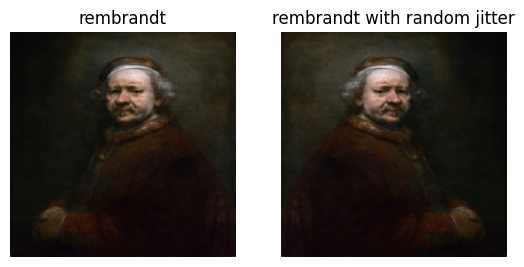

In [ ]:
# Monet With and without Random Jitter
plt.subplot(121).set_title('rembrandt')
plt.imshow(sample_rembrandt[0] * 0.5 + 0.5)  # Assuming you want the first image in the batch
plt.axis('off')

plt.subplot(122).set_title('rembrandt with random jitter')
plt.imshow(random_jitter(sample_rembrandt[0]) * 0.5 + 0.5)
plt.axis('off')








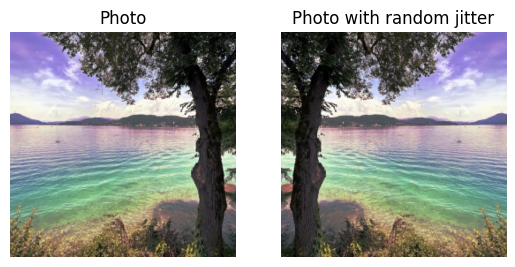

In [ ]:
#photo with and without Random Jitter
plt.subplot(121).set_title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122).set_title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)
plt.axis('off');



plt.show()


In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

## Loss functions

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# **Training**

In [ ]:
EPOCHS = 20

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

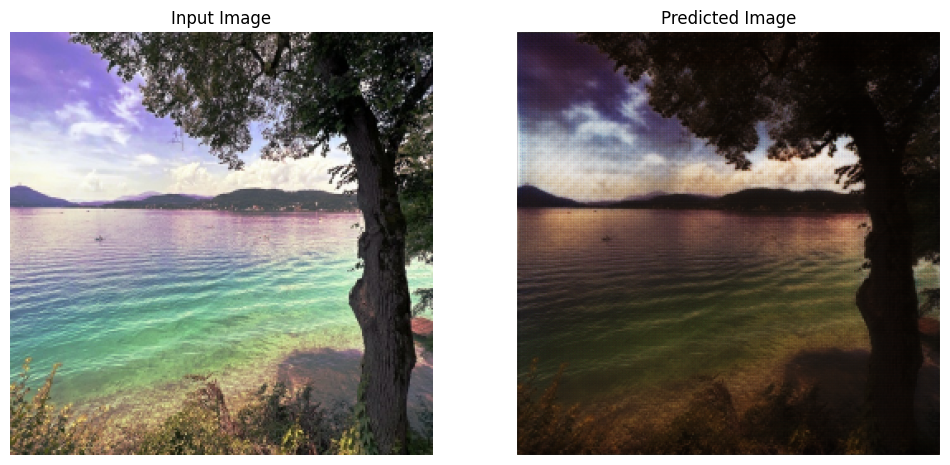

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20 is 111.53901052474976 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip(( photo_train, rembrandt_train)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_monet) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

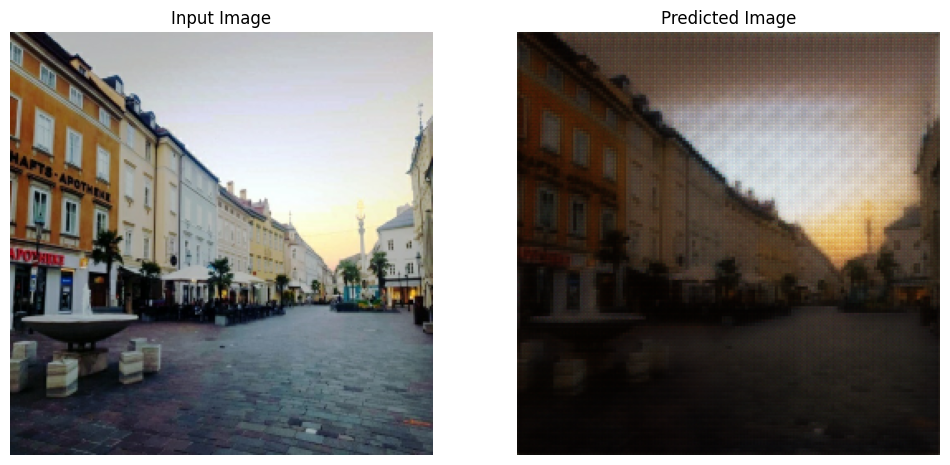

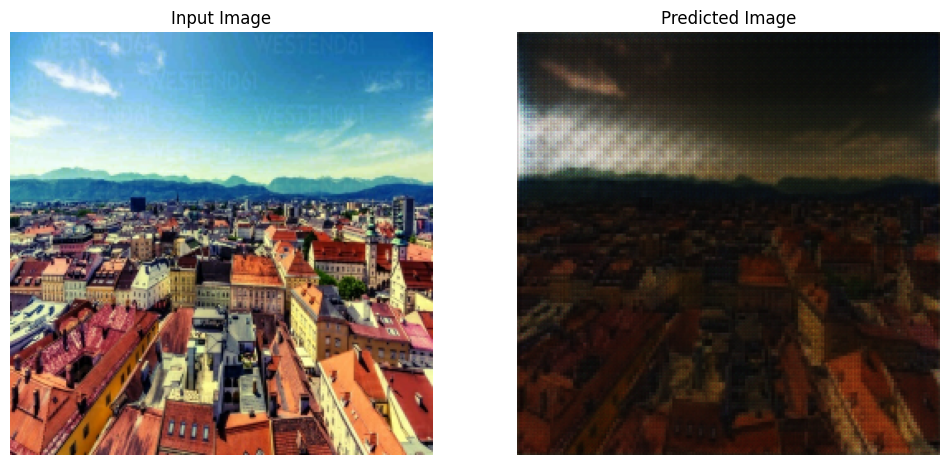

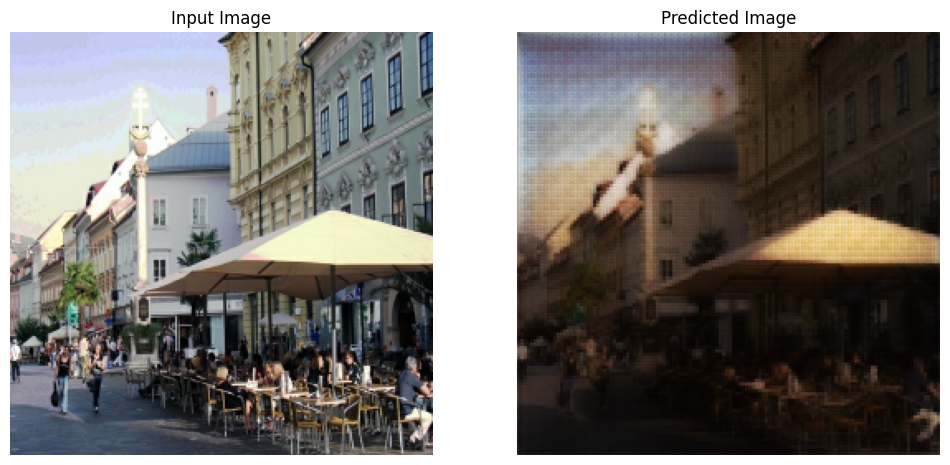

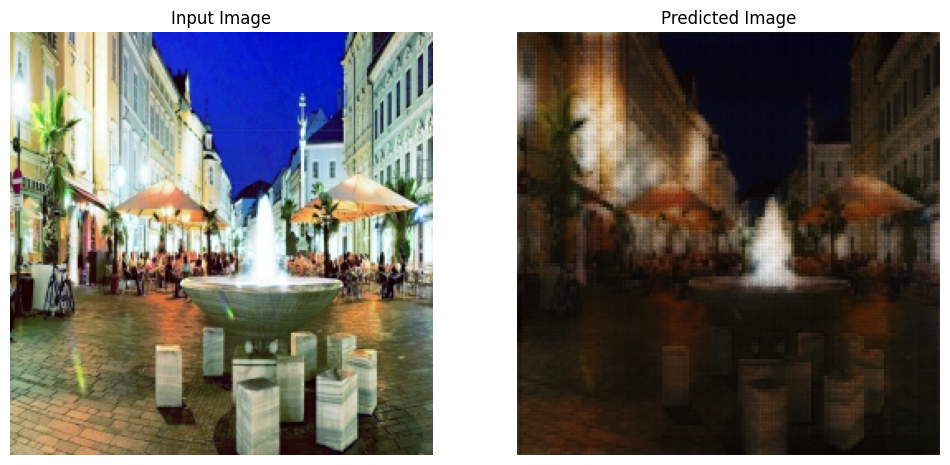

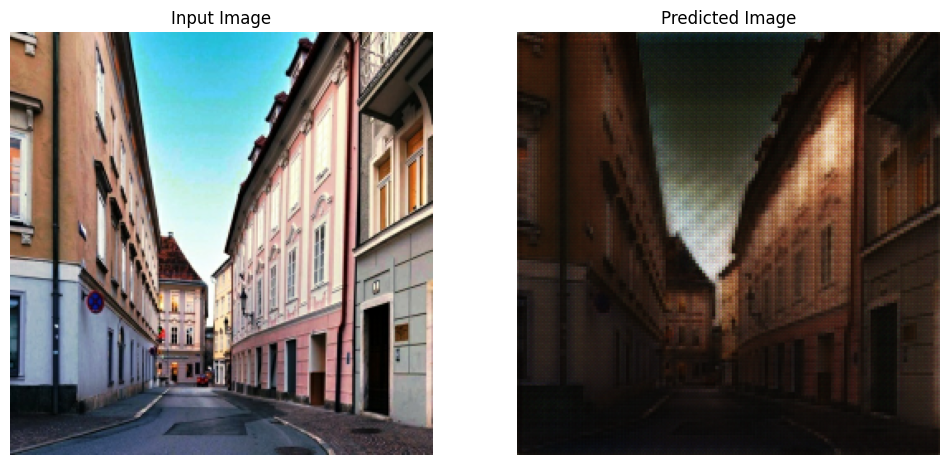

In [ ]:
# Run the trained model on the test dataset
for inp in photo_test.take(10):
  generate_images(generator_g, inp)